# Maritime Trade: Train 2020 XGBoost GPU
## Hyperopt Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install xgboost==1.5.2
!pip install eli5
!pip install shap
import os
import random
import numpy as np
import warnings
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 
from eli5.sklearn import PermutationImportance 
import webbrowser
from eli5.formatters import format_as_dataframe
import shap
warnings.filterwarnings('ignore')
my_dpi = 96
print('\n')
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 858 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173.6 MB 6.5 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 58.7 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=faf088e21eb40665376d99871dc72798dfe12c3dae3a12422d1b9f47153a8629
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Fo

In [ ]:
# Set seed 
seed_value = 42
os.environ['xgbGPU_train20test19'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633772, 20)


In [ ]:
# Drop time and COVID-19 vars
df = df.drop(['DateTime'], axis=1)

In [ ]:
# Filter df to 2019
df1 = df[df['Year'] == 2019]

# Filter df to 2020
df2 = df[df['Year'] == 2020]

# Drop year variable
df1 = df1.drop(['Year'], axis=1)
df2 = df2.drop(['Year'], axis=1)

del df

In [ ]:
# Prepare 2020 for partitioning data
X = df2.drop(['Metric_Tons'], axis=1)
y = df2['Metric_Tons']

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=seed_value)

In [ ]:
# Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(mn.transform(X_test), columns=X_test.columns)

## 100 Trials 10-Fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value)

xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.5),  
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10, 
                                                                dtype=int))
    }

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    """XGBoost HPO"""
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBRegressor(
        objective='reg:squarederror',
        booster='gbtree', 
        tree_method='gpu_hist',    
        scale_pos_weight=1,
        use_label_encoder=False,
        random_state=seed_value,        
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                              scoring='neg_root_mean_squared_error',
                              cv=kfolds)
    run_time = timer() - start
    
    # Extract the best score
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'XGB_HPO_train20test20_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-19 23:02:31.189549
100%|██████████| 100/100 [7:08:10<00:00, 256.90s/it, best loss: 11.429513200945216]
Start Time           2022-02-19 23:02:31.189549
End Time             2022-02-20 06:10:41.266549
7:08:10


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 11.429513200945216, 'params': {'colsample_bylevel': 0.3897179209616464, 'colsample_bytree': 0.7951970379567552, 'gamma': 3.588635385058162, 'learning_rate': 0.16633071459750554, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 491, 'reg_alpha': 27, 'reg_lambda': 0.6489865924994325, 'subsample': 0.7128150169021927}, 'iteration': 84, 'train_time': 713.9317692730001, 'status': 'ok'}, {'loss': 11.489268064035326, 'params': {'colsample_bylevel': 0.3651305125020261, 'colsample_bytree': 0.910338468686789, 'gamma': 3.7095215045465673, 'learning_rate': 0.07473781230452001, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 477, 'reg_alpha': 12, 'reg_lambda': 1.132510712366058, 'subsample': 0.7006666417976207}, 'iteration': 88, 'train_time': 713.6926352910014, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_train20test20_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                random_state=seed_value,
                                verbosity=0, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_train20test20_100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_train20test20_100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train 2020 Test 2020 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO Train 2020 Test 2020 100 GPU trials
MAE train: 4.215, test: 8.278
MSE train: 67.418, test: 267.650
RMSE train: 8.211, test: 16.360
R^2 train: 0.892, test: 0.567


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 258.62480 MSE on the test set.
This was achieved after 84 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_train20test20_100_GPU.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

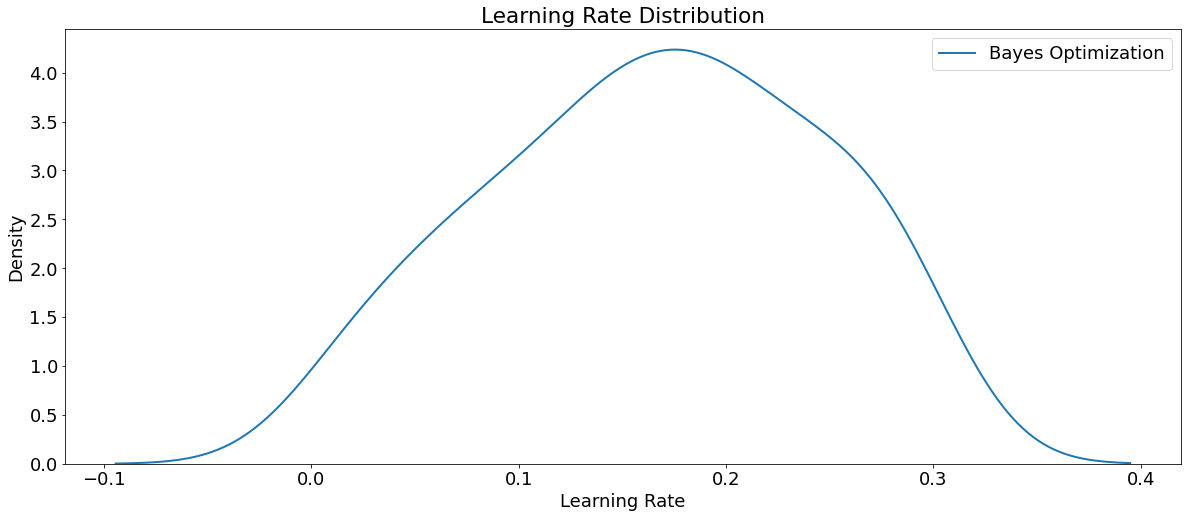

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

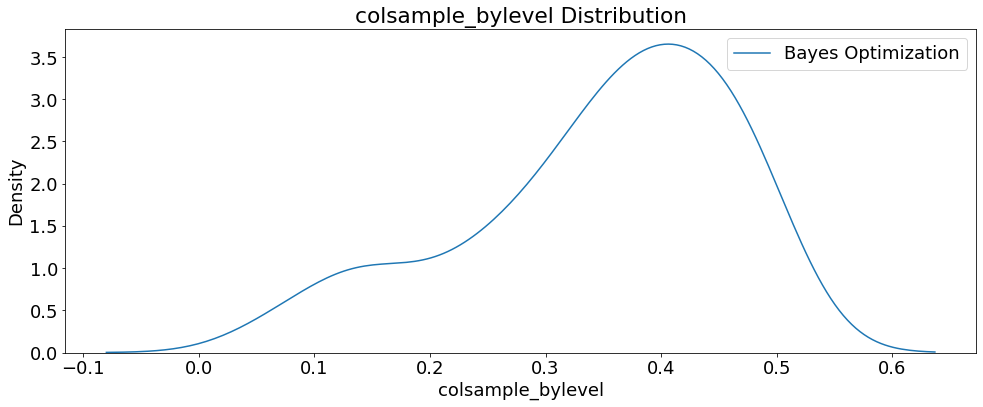

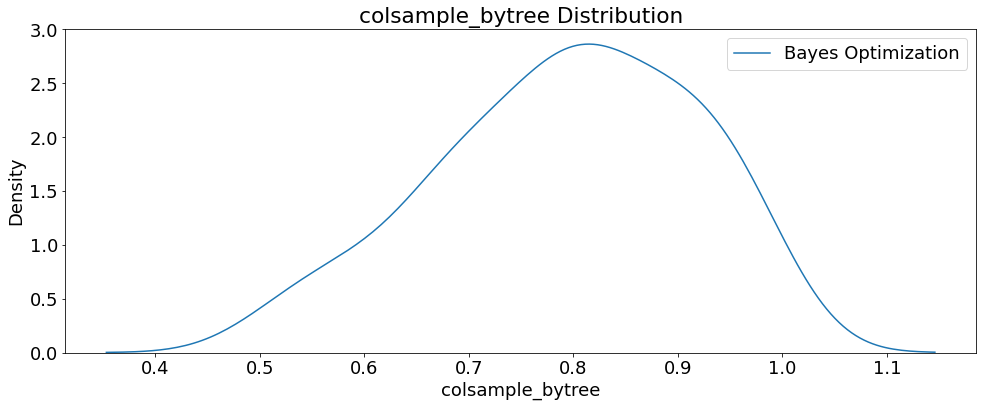

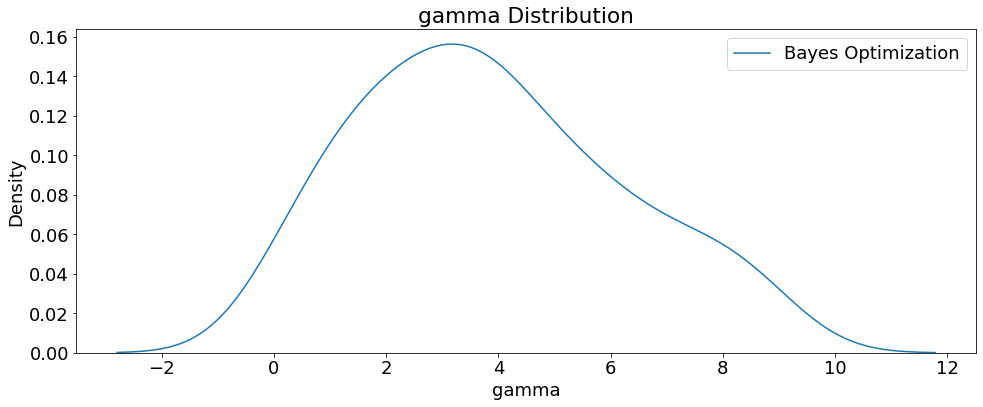

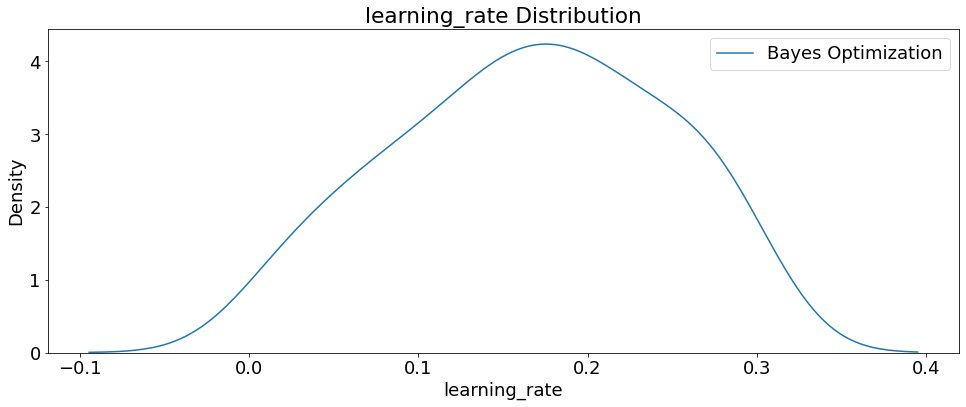

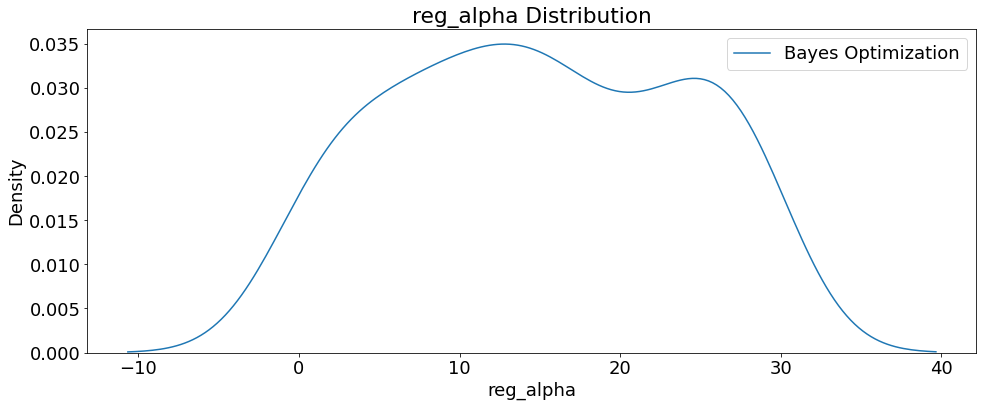

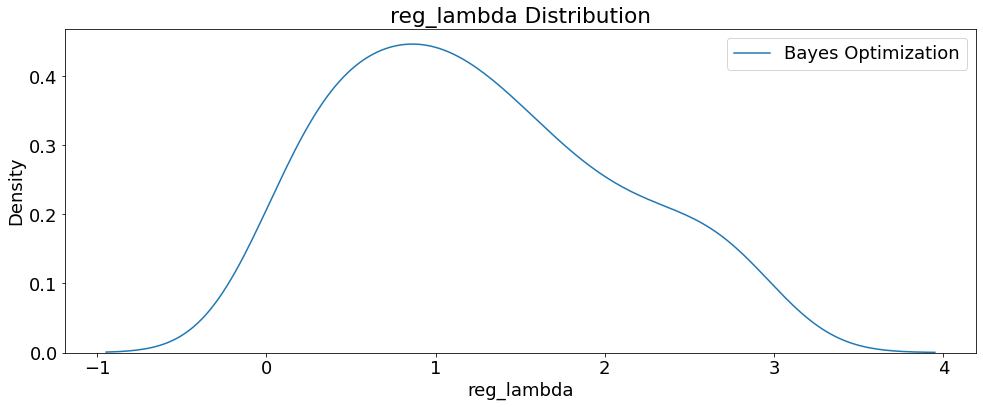

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

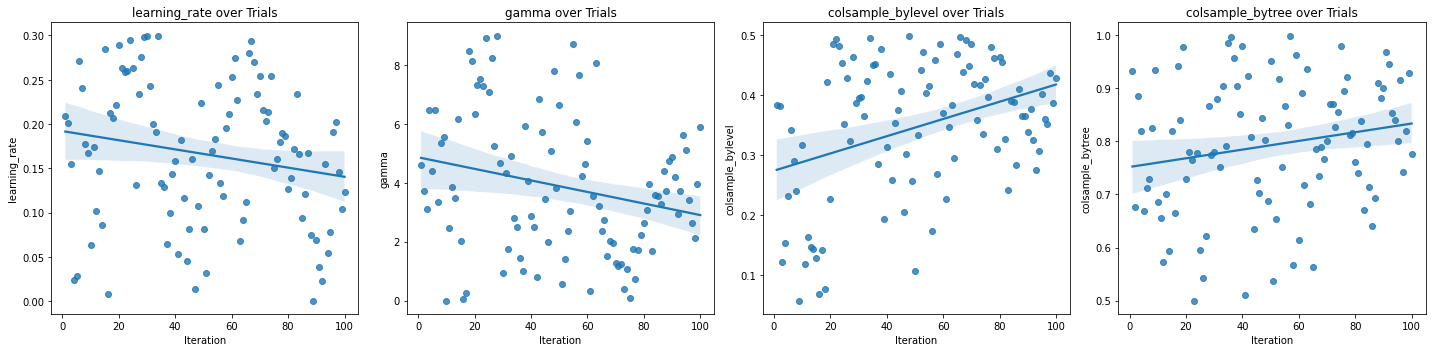

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

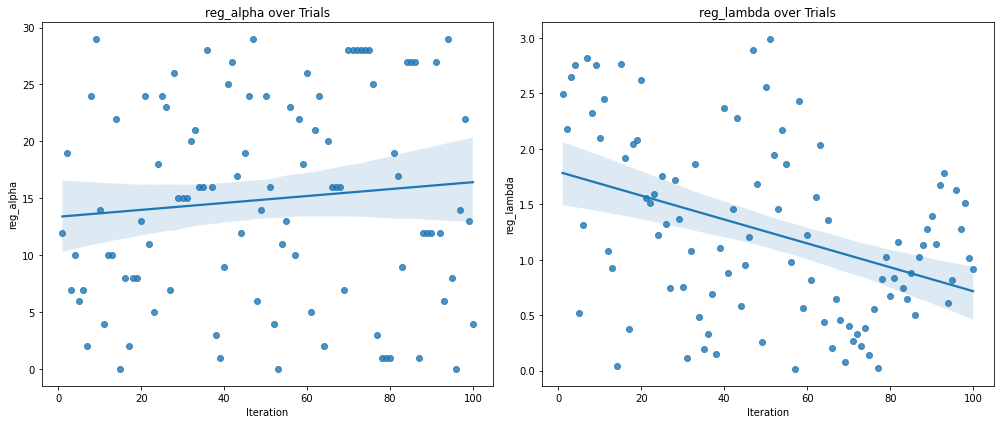

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
  title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


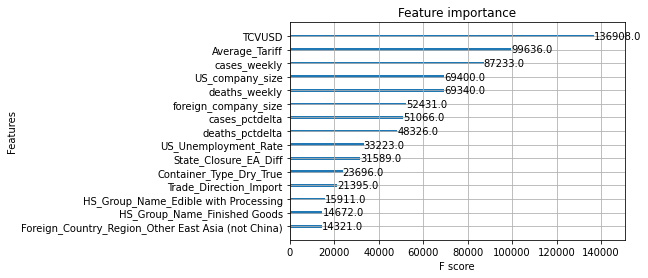

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train20test20_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_100_GPU_train20test20_ShapForcePlot_TrainSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

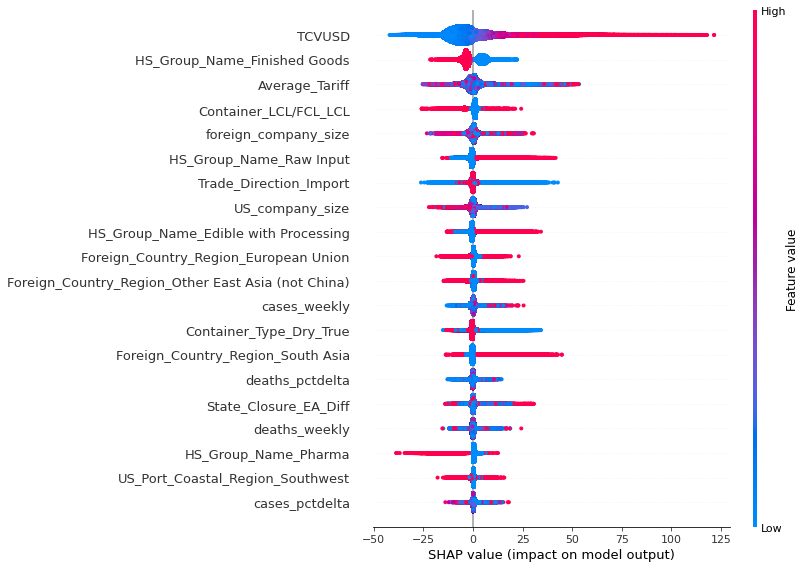

In [ ]:
# Training Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGBoost_HPO_100_GPU_train20test20_ShapSummary_TrainSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True, figsize=(60,3)).savefig('XGBoost_HPO_100_GPU_train20test20_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

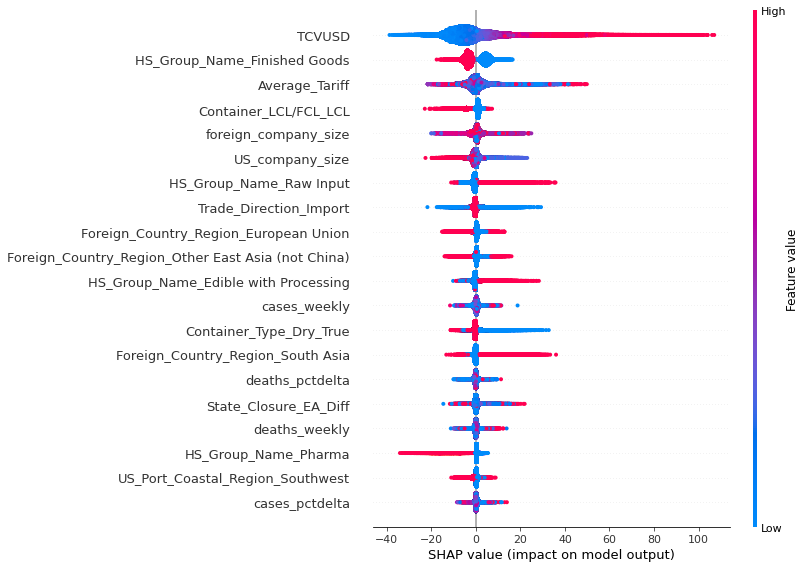

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGBoost_HPO_100_GPU_train20test20_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test20_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test20_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train20test20_HPO_100_GPU_WeightsExplain.csv',
           index=False)
exp

feature    weight       std
0                                              TCVUSD  0.880002  0.000995
1                                      Average_Tariff  0.330360  0.000676
2                        HS_Group_Name_Finished Goods  0.145620  0.000632
3                              Trade_Direction_Import  0.121966  0.000885
4                             HS_Group_Name_Raw Input  0.087500  0.000227
5                                        cases_weekly  0.066665  0.000519
6                                     deaths_pctdelta  0.056272  0.000358
7                                       deaths_weekly  0.054949  0.000417
8                HS_Group_Name_Edible with Processing  0.047545  0.000641
9                             Container_Type_Dry_True  0.047018  0.000811
10                  Foreign_Country_Region_South Asia  0.046925  0.000456
11                               HS_Group_Name_Pharma  0.044682  0.000160
12                              State_Closure_EA_Diff  0.040277  0.000626
13                                     cases_pctdelta  0.037247  0.000562
14              Foreign_Country_Region_European Union  0.027659  0.000211
15  Foreign_Country_Region_Other East Asia (not Ch...  0.027059  0.000420
16              Foreign_Country_Region_Southeast Asia  0.023072  0.000299
17                              Container_LCL/FCL_LCL  0.019998  0.000705
18               Foreign_Country_Region_South America  0.019081  0.000331
19                   US_Port_Coastal_Region_Northwest  0.016832  0.000153

### Test trained 2020 model on 2019

In [ ]:
# Prepare 2020 to fit model train on 2019
X_test1 = df1.drop(['Metric_Tons'], axis=1)
y_test1 = df1['Metric_Tons']

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Fit the model
best_bayes_model_19.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2020 Test 2019')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2020 Test 2019
MAE train: 4.215, test: 14.023
MSE train: 67.418, test: 45296.146
RMSE train: 8.211, test: 212.829
R^2 train: 0.892, test: 0.866


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


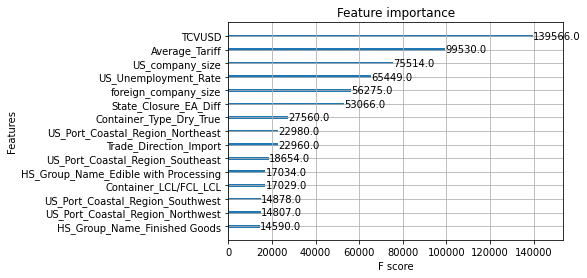

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train20test19_10_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

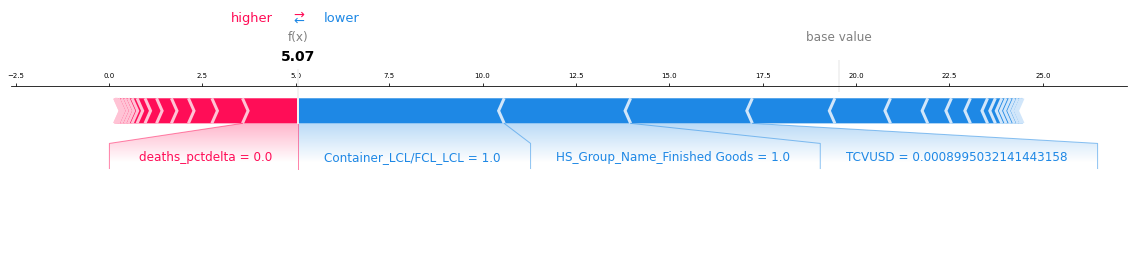

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGBoost_HPO_100_GPU_train20test19_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi*10, 
                                                     bbox_inches='tight');

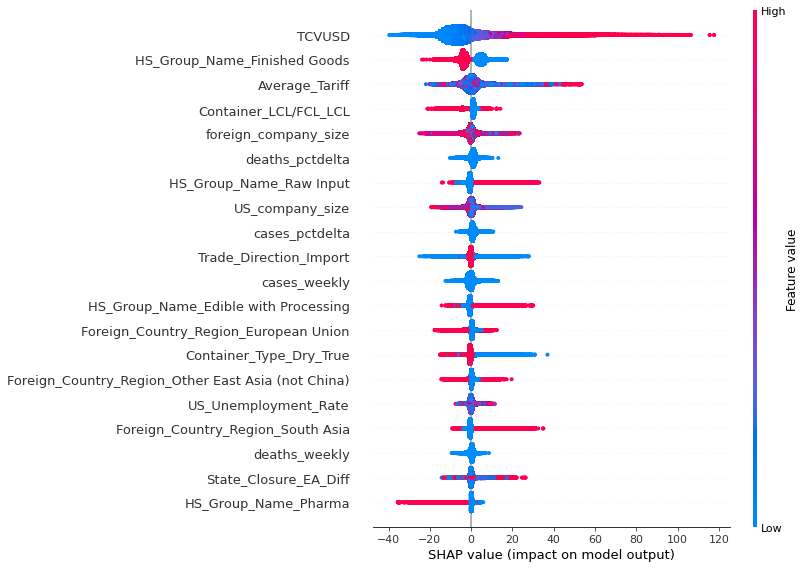

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_100_GPU_train20test19_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test19_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test19_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train20test19_HPO_100_GPU_WeightsExplain.csv',
           index=False)
exp

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  0.918738  0.001041
1                                      Average_Tariff  0.307158  0.000603
2                        HS_Group_Name_Finished Goods  0.124695  0.000475
3                             HS_Group_Name_Raw Input  0.121872  0.000127
4                              Trade_Direction_Import  0.114249  0.000286
5                             Container_Type_Dry_True  0.059826  0.000171
6               Foreign_Country_Region_European Union  0.044746  0.000217
7                               State_Closure_EA_Diff  0.043981  0.000201
8   Foreign_Country_Region_Other East Asia (not Ch...  0.036932  0.000234
9                HS_Group_Name_Edible with Processing  0.032700  0.000203
10                  Foreign_Country_Region_South Asia  0.031284  0.000088
11                              Container_LCL/FCL_LCL  0.027712  0.000212
12                               HS_Group_Name_Pharma  0.024898  0.000044
13                   US_Port_Coastal_Region_Southeast  0.020381  0.000132
14                   US_Port_Coastal_Region_Northeast  0.020221  0.000120
15               Foreign_Country_Region_South America  0.019392  0.000054
16              Foreign_Country_Region_Southeast Asia  0.016685  0.000162
17               Foreign_Country_Region_North America  0.014606  0.000106
18                                    US_company_size  0.014467  0.000318
19                   US_Port_Coastal_Region_Northwest  0.013362  0.000143

### Test trained 2020 Model on 2018-19

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna() & 
        df.State_Closure_EA_Diff.notna()]
df = df.loc[(df['Year'] >= 2018) & (df['Year'] < 2020)]

# Examine distribution of year data
df[['Year']].value_counts()

Year  
2018.0    3080375
2019.0    2978984
dtype: int64

In [ ]:
# Prepare 2018-19 to fit model train on 2020
X_test1 = df.drop(['Metric_Tons', 'DateTime', 'Year'], axis=1)
y_test1 = df['Metric_Tons']

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2020 Test 2018-19')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2020 Test 2018-19
MAE train: 4.215, test: 15.180
MSE train: 67.418, test: 55360.890
RMSE train: 8.211, test: 235.289
R^2 train: 0.892, test: 0.844


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


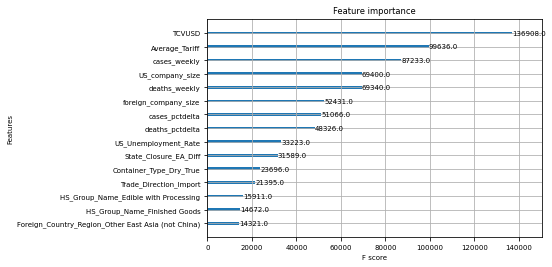

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train20test1819_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

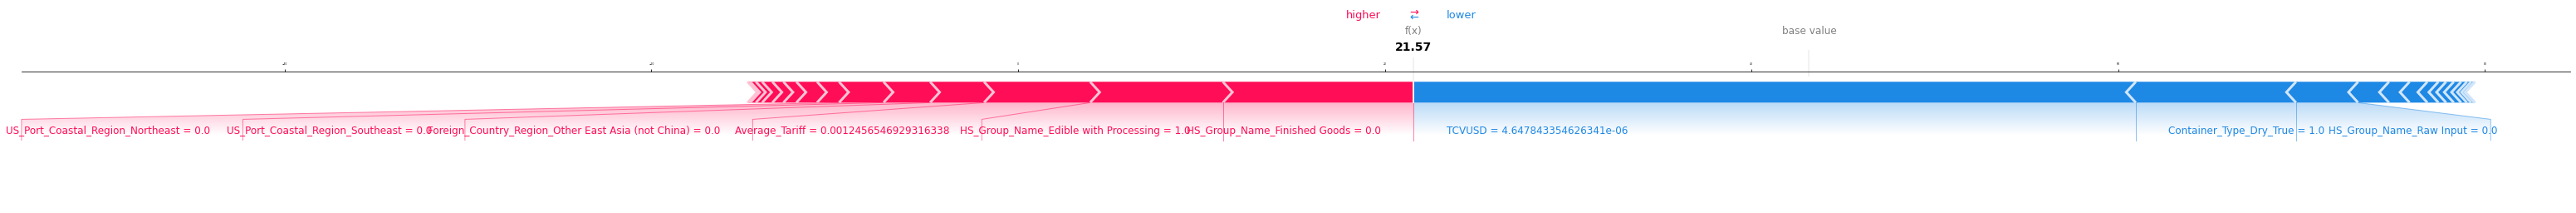

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(40,3)).savefig('XGBoost_HPO_100_GPU_train20test1819_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

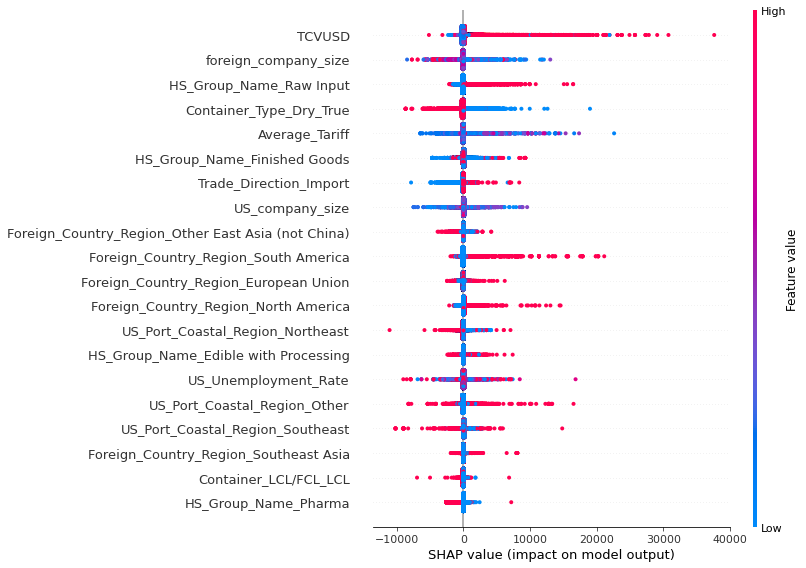

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_100_GPU_train20test1819_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test1819_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test1819_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train20test1819_HPO_100_GPU_WeightsExplain.csv',
           index=False)
exp

feature    weight       std
0                                              TCVUSD  1.126283  0.008412
1                                      Average_Tariff  0.873237  0.019340
2                                foreign_company_size  0.509893  0.012614
3                             HS_Group_Name_Raw Input  0.440525  0.007146
4                              Trade_Direction_Import  0.416595  0.003297
5                             Container_Type_Dry_True  0.347082  0.013267
6                Foreign_Country_Region_South America  0.298110  0.010992
7                        HS_Group_Name_Finished Goods  0.265239  0.008155
8                                     US_company_size  0.229411  0.008114
9                                US_Unemployment_Rate  0.148124  0.004510
10  Foreign_Country_Region_Other East Asia (not Ch...  0.128546  0.001564
11                               HS_Group_Name_Pharma  0.116811  0.000767
12                   US_Port_Coastal_Region_Northwest  0.112178  0.005751
13               Foreign_Country_Region_North America  0.105169  0.004465
14                       US_Port_Coastal_Region_Other  0.095462  0.002249
15                   US_Port_Coastal_Region_Southeast  0.093675  0.003095
16  Foreign_Country_Region_Other Europe (not Europ...  0.082890  0.001136
17                   US_Port_Coastal_Region_Northeast  0.079435  0.007720
18                                HS_Group_Name_Vices  0.077663  0.005038
19                   US_Port_Coastal_Region_Southwest  0.076304  0.002412

### Test trained 2020 model on 2010-19

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna() & 
        df.State_Closure_EA_Diff.notna()]
df = df[df['Year'] < 2020]
print('Number of rows and columns:', df.shape)

Number of rows and columns: (24133210, 19)


In [ ]:
# Sample due to memory constraints
df_sample = df.sample(n=10000000)

del df

In [ ]:
# Prepare 2018-19 to fit model train on 2020
X_test1 = df_sample.drop(['Metric_Tons'], axis=1)
y_test1 = df_sample['Metric_Tons']

del df_sample

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2020 Test PreCovid')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2020 Test PreCovid
MAE train: 4.215, test: 21.981
MSE train: 67.418, test: 80410.597
RMSE train: 8.211, test: 283.568
R^2 train: 0.892, test: 0.794


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


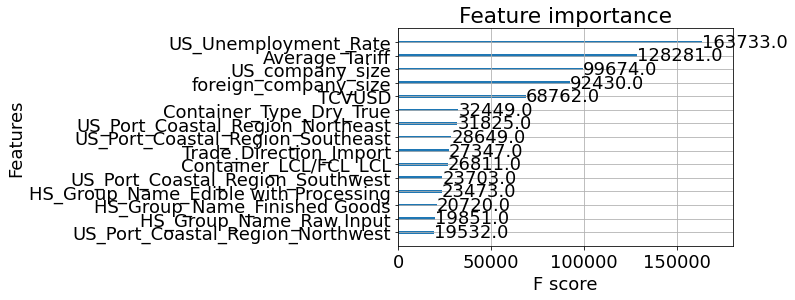

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train20testPreCovid_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
check_additivity = False
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1, check_additivity=check_additivity)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

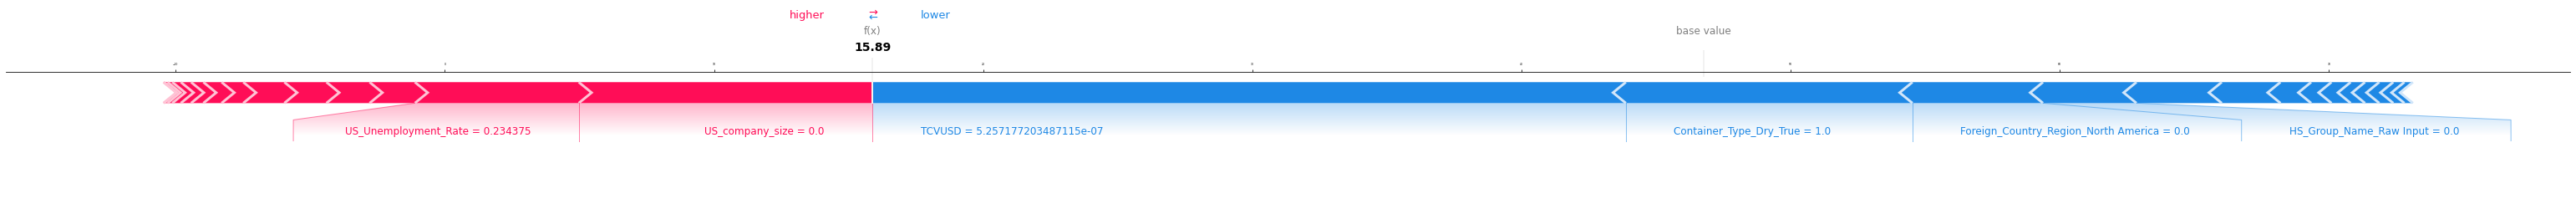

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_100_GPU_train20testPreCovid_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

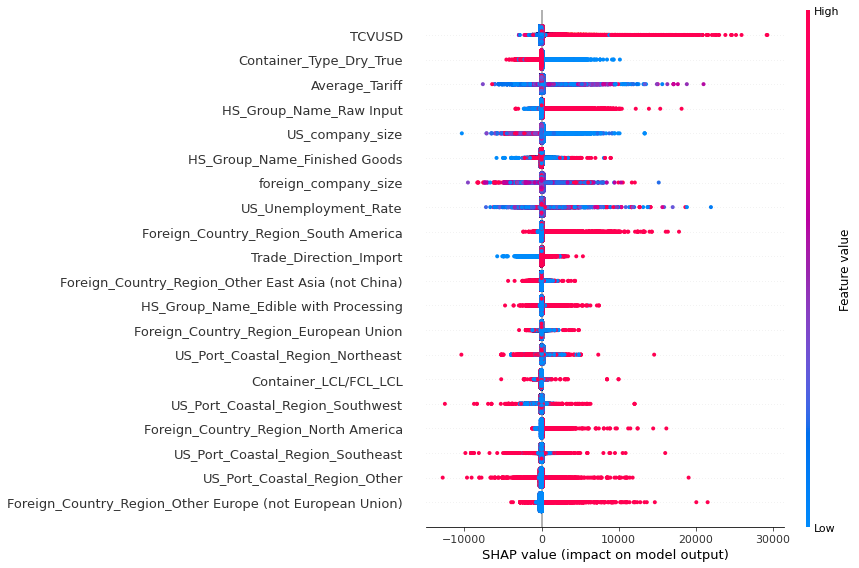

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_100_GPU_train20testPreCovid_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20testPreCovid_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20testPreCovid_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train20testPreCovid_HPO_100_GPU_WeightsExplain.csv',
           index=False)

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  1.345337  0.005255
1                                      Average_Tariff  0.739878  0.005633
2                                US_Unemployment_Rate  0.565351  0.010282
3                                     US_company_size  0.326759  0.008432
4               Foreign_Country_Region_Southeast Asia  0.325393  0.005212
5   Foreign_Country_Region_Middle East & North Africa  0.303560  0.003003
6                                foreign_company_size  0.298898  0.006055
7                             Container_Type_Dry_True  0.262825  0.001138
8                                 HS_Group_Name_Vices  0.237584  0.013079
9                Foreign_Country_Region_South America  0.198521  0.001976
10              Foreign_Country_Region_European Union  0.103615  0.001856
11                            HS_Group_Name_Raw Input  0.100470  0.008053
12  Foreign_Country_Region_Other Europe (not Europ...  0.097103  0.000940
13               HS_Group_Name_Edible with Processing  0.089237  0.004316
14                             Trade_Direction_Import  0.081552  0.002771
15                               HS_Group_Name_Pharma  0.079837  0.001804
16                   US_Port_Coastal_Region_Southwest  0.073377  0.000755
17                       HS_Group_Name_Finished Goods  0.072106  0.004282
18                   US_Port_Coastal_Region_Northwest  0.060017  0.002727
19                     Foreign_Country_Region_Oceania  0.057038  0.001990

## 300 Trials 10-Fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 300

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'XGB_HPO_train20test20_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

# Finished 263/300 at 19h 50m 20s

Start Time           2022-02-15 23:22:29.405381
 88%|████████▊ | 263/300 [19:49:49<4:23:58, 428.05s/it, best loss: 11.271549077068723]

In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_train20test20_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                random_state=seed_value,
                                verbosity=0, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_train20test20_300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_train20test20_300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train 2020 Test 2020 300 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO Train 2020 Test 2020 300 GPU trials
MAE train: 4.145, test: 7.858
MSE train: 67.579, test: 260.901
RMSE train: 8.221, test: 16.152
R^2 train: 0.891, test: 0.578


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 251.43117 MSE on the test set.
This was achieved after 177 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_train19test19_300_GPU.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

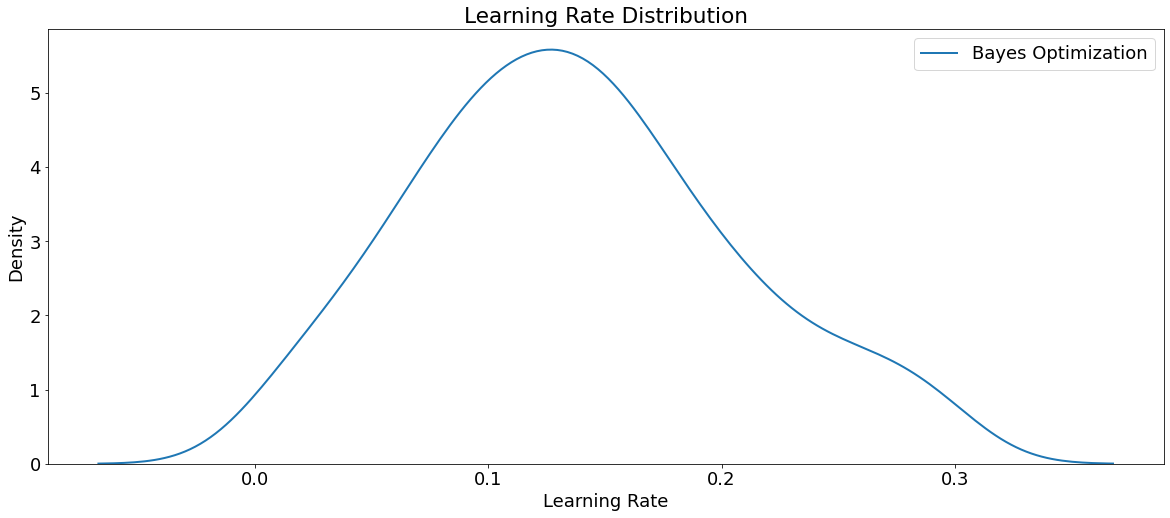

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

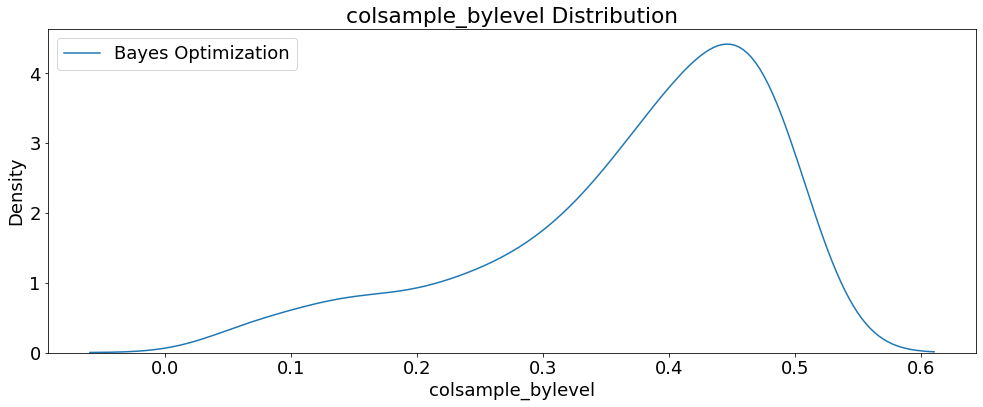

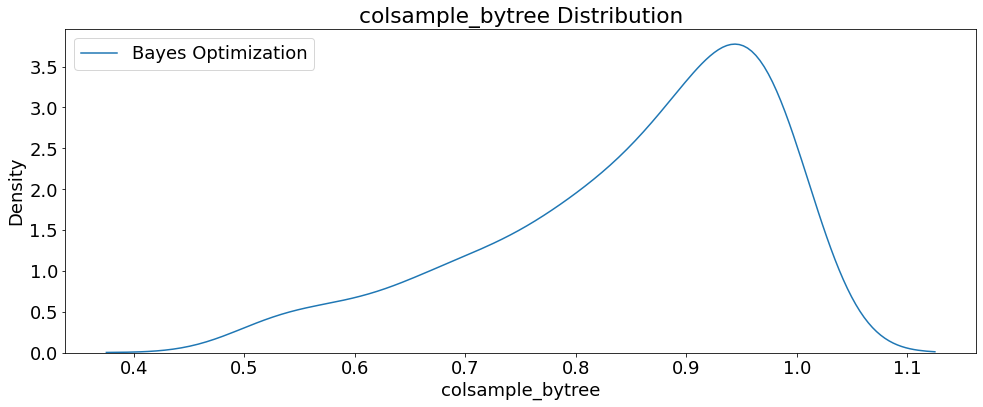

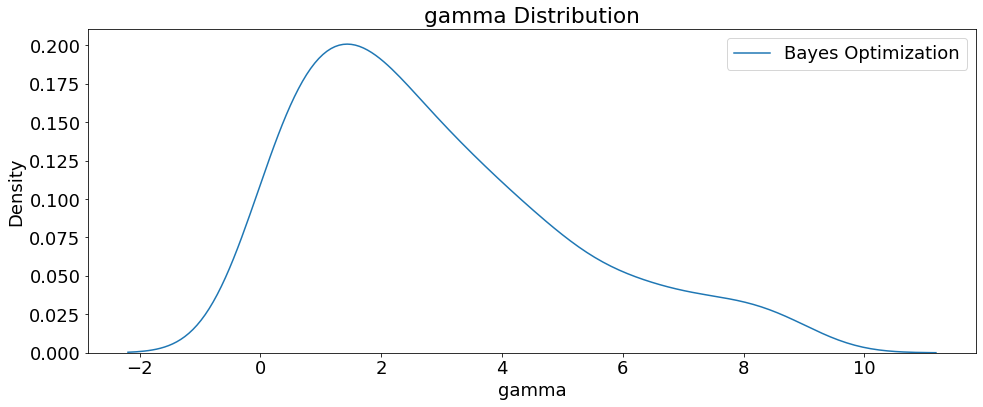

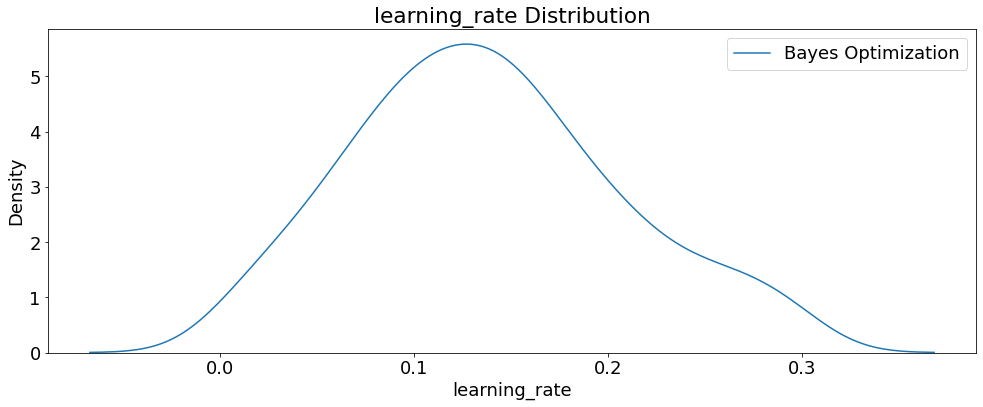

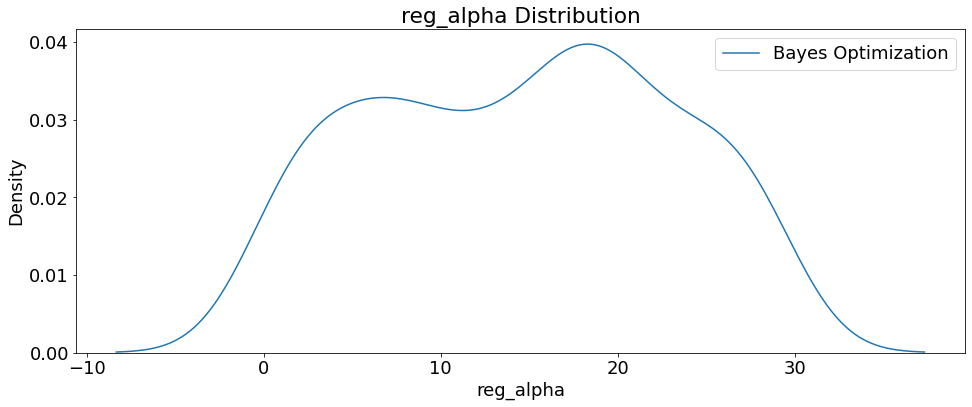

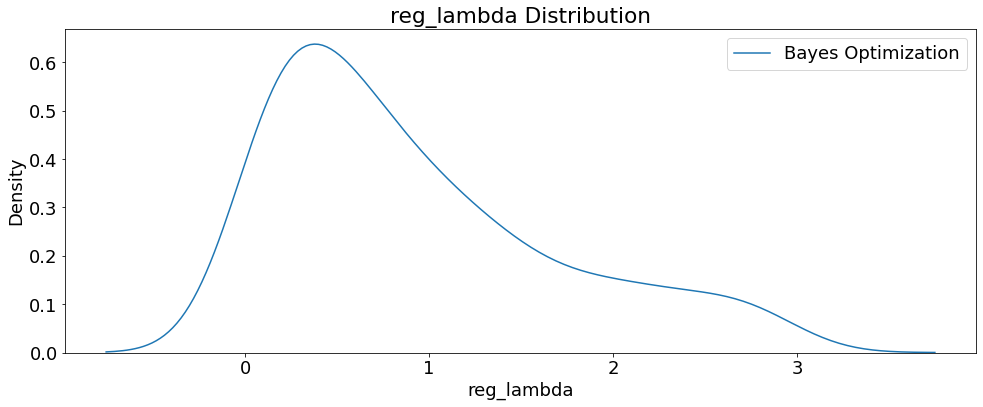

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']: 
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss': 
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

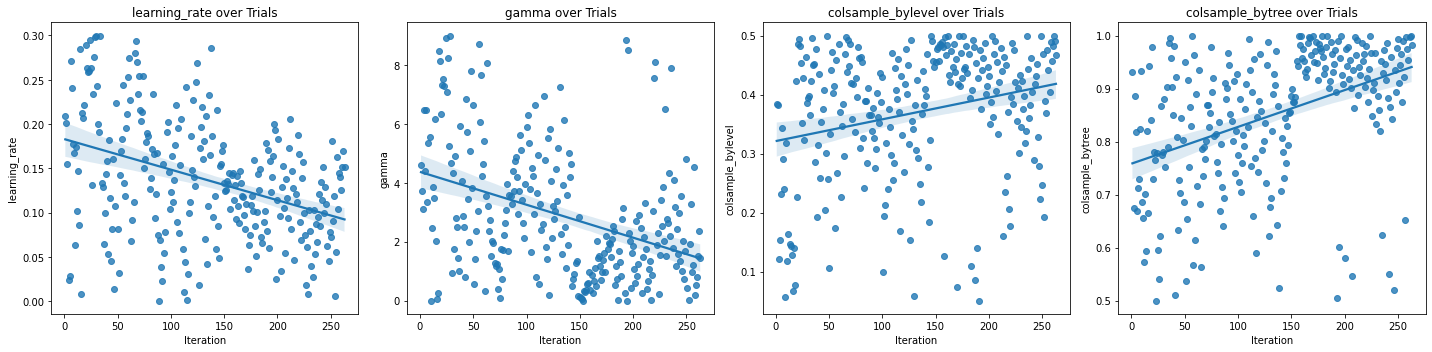

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

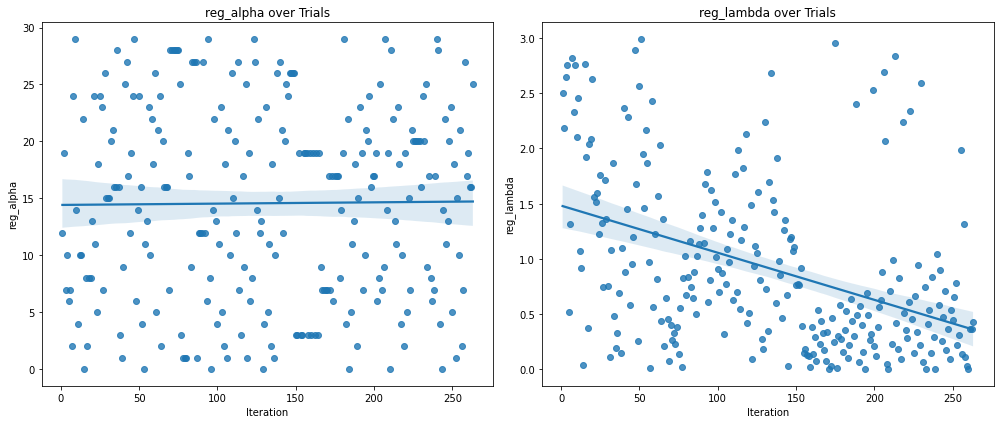

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
  title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


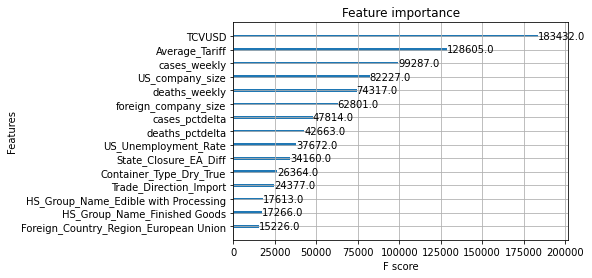

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train20test20_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

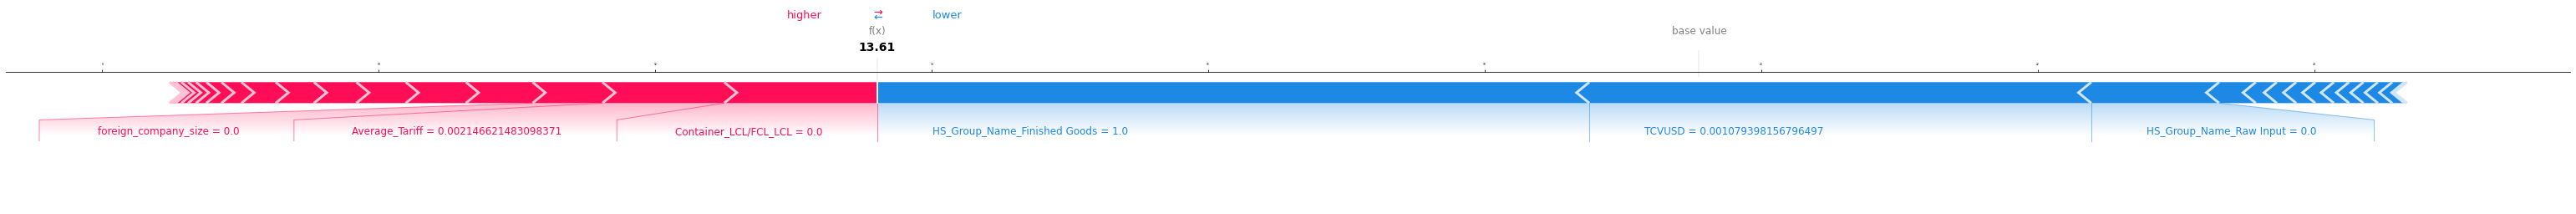

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_300_GPU_train20test20_ShapForcePlot_TrainSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

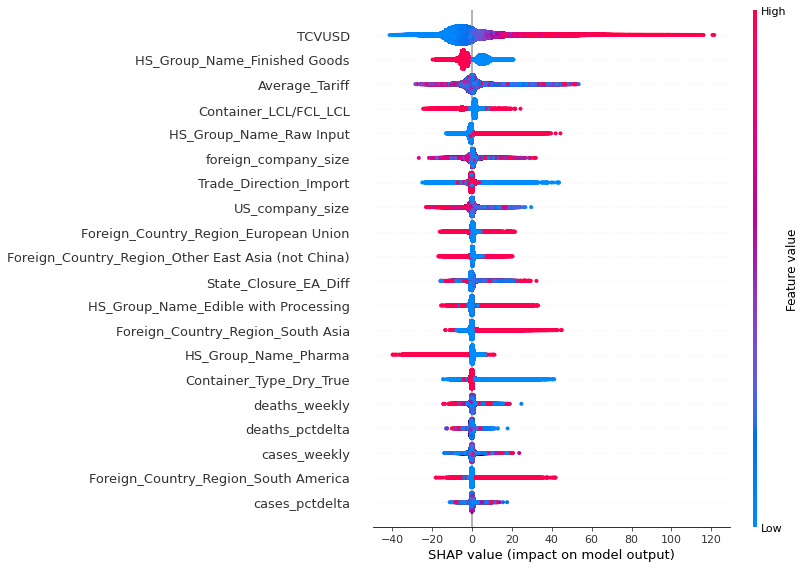

In [ ]:
# Training Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train20test20_ShapSummary_TrainSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

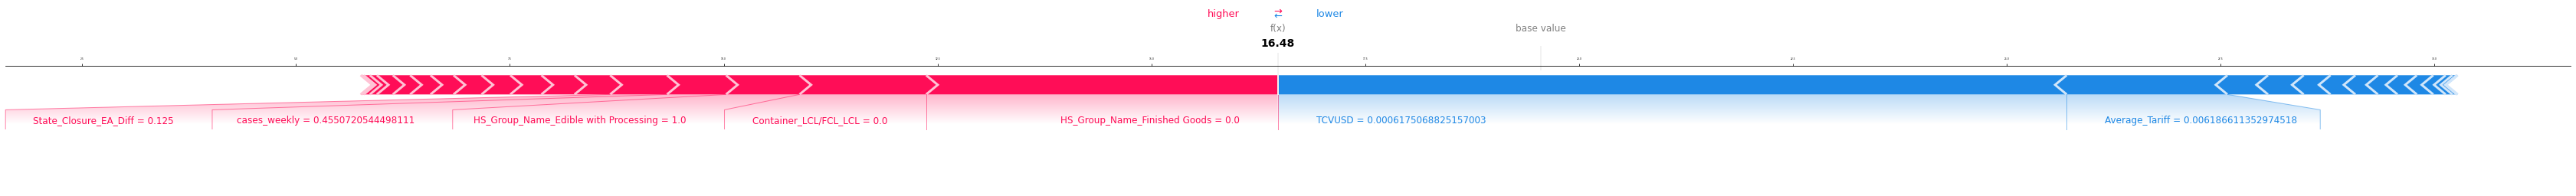

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True, figsize=(60,3)).savefig('XGBoost_HPO_300_GPU_train20test20_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

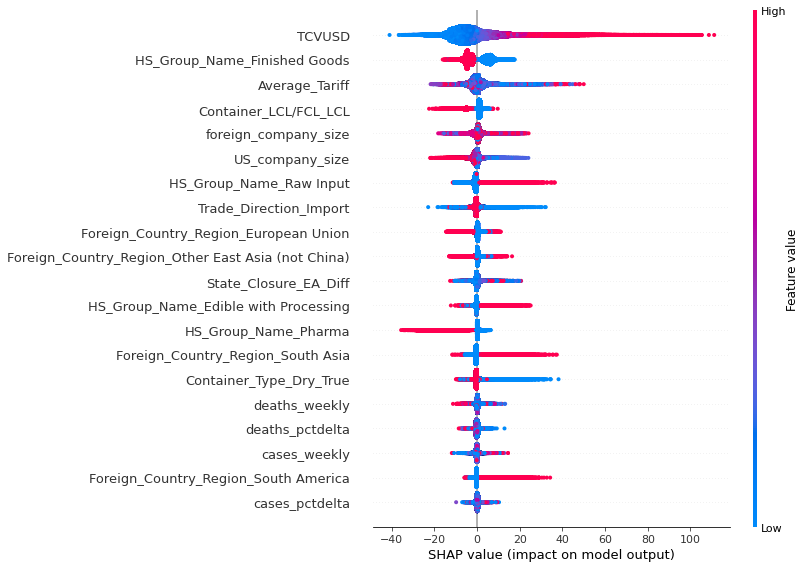

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train20test20_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test20_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test20_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train20test20_HPO_300_GPU_WeightsExplain.csv',
           index=False)
exp

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  0.902339  0.001530
1                                      Average_Tariff  0.313240  0.000406
2                              Trade_Direction_Import  0.131249  0.000976
3                        HS_Group_Name_Finished Goods  0.126536  0.000293
4                             HS_Group_Name_Raw Input  0.113418  0.000809
5                                       deaths_weekly  0.084948  0.000463
6                                        cases_weekly  0.082834  0.000516
7                             Container_Type_Dry_True  0.050583  0.000557
8                HS_Group_Name_Edible with Processing  0.048800  0.000227
9                                     deaths_pctdelta  0.047809  0.000348
10                              State_Closure_EA_Diff  0.046493  0.000470
11                  Foreign_Country_Region_South Asia  0.045814  0.000564
12                                     cases_pctdelta  0.042478  0.000320
13                               HS_Group_Name_Pharma  0.040936  0.000112
14  Foreign_Country_Region_Other East Asia (not Ch...  0.026864  0.000710
15              Foreign_Country_Region_European Union  0.025665  0.000375
16                              Container_LCL/FCL_LCL  0.025263  0.000545
17              Foreign_Country_Region_Southeast Asia  0.021810  0.000277
18               Foreign_Country_Region_South America  0.018566  0.000218
19                   US_Port_Coastal_Region_Northeast  0.016317  0.000223

### Test trained 2020 Model on 2019

In [ ]:
# Prepare 2020 to fit model train on 2019
X_test1 = df1.drop(['Metric_Tons'], axis=1)
y_test1 = df1['Metric_Tons']

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
print('\nModel Metrics for XGBoost HPO Train 2019 Test 2020')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2019 Test 2020
MAE train: 4.145, test: 12.948
MSE train: 67.579, test: 45158.233
RMSE train: 8.221, test: 212.505
R^2 train: 0.891, test: 0.867


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


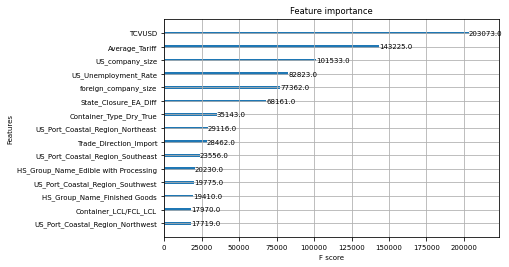

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train20test19_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

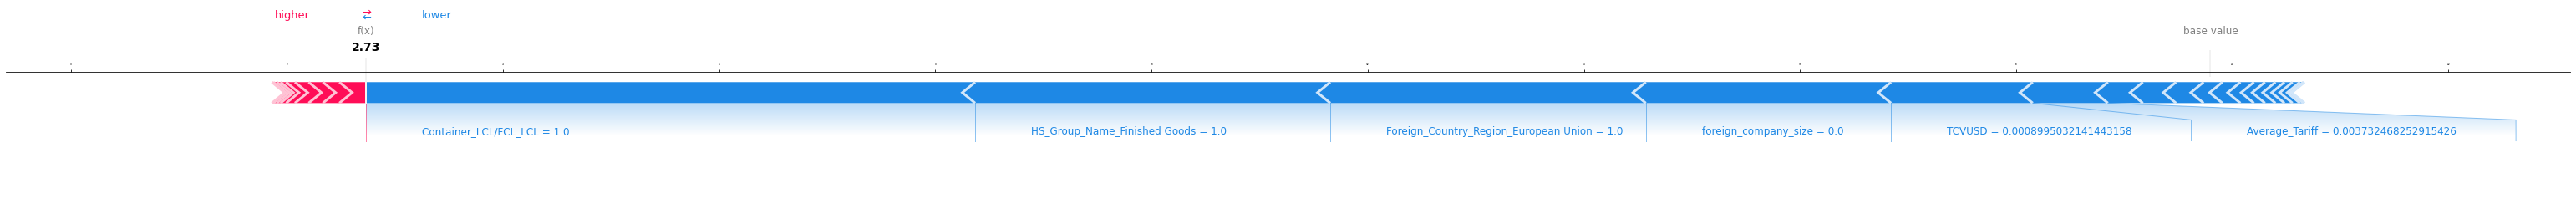

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_300_GPU_train20test19_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

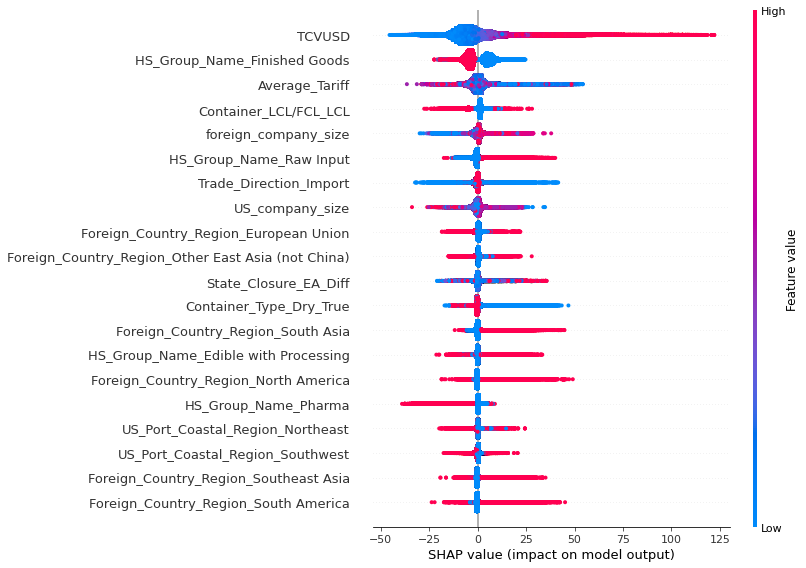

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train20test19_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test19_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test19_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train20test19_HPO_300_GPU_WeightsExplain.csv', 
           index=False)
exp

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  0.914720  0.001265
1                                      Average_Tariff  0.302998  0.000530
2                              Trade_Direction_Import  0.118481  0.000275
3                        HS_Group_Name_Finished Goods  0.115965  0.000483
4                             HS_Group_Name_Raw Input  0.101722  0.000238
5                             Container_Type_Dry_True  0.060326  0.000196
6                   Foreign_Country_Region_South Asia  0.047098  0.000184
7                               State_Closure_EA_Diff  0.046654  0.000190
8                HS_Group_Name_Edible with Processing  0.046555  0.000260
9                               Container_LCL/FCL_LCL  0.032550  0.000225
10                               HS_Group_Name_Pharma  0.032191  0.000062
11  Foreign_Country_Region_Other East Asia (not Ch...  0.029606  0.000118
12              Foreign_Country_Region_European Union  0.025526  0.000114
13                   US_Port_Coastal_Region_Northeast  0.021642  0.000118
14                   US_Port_Coastal_Region_Southeast  0.018158  0.000083
15               Foreign_Country_Region_North America  0.017896  0.000097
16              Foreign_Country_Region_Southeast Asia  0.017093  0.000150
17               Foreign_Country_Region_South America  0.016781  0.000069
18                                    US_company_size  0.015406  0.000461
19                   US_Port_Coastal_Region_Northwest  0.015206  0.000141

### Test trained 2020 Model on 2018-19

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna() & 
        df.State_Closure_EA_Diff.notna()]

# Subset years for training
df = df.loc[(df['Year'] >= 2018) & (df['Year'] < 2020)]

# Examine distribution of year data
df[['Year']].value_counts()

Year  
2018.0    3080375
2019.0    2978984
dtype: int64

In [ ]:
# Prepare 2018-19 to fit model train on 2020
X_test1 = df.drop(['Metric_Tons', 'Year', 'DateTime'], axis=1)
y_test1 = df['Metric_Tons']

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2020 Test 2018-19')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2020 Test 2018-19
MAE train: 4.145, test: 14.278
MSE train: 67.579, test: 54993.164
RMSE train: 8.221, test: 234.506
R^2 train: 0.891, test: 0.845


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


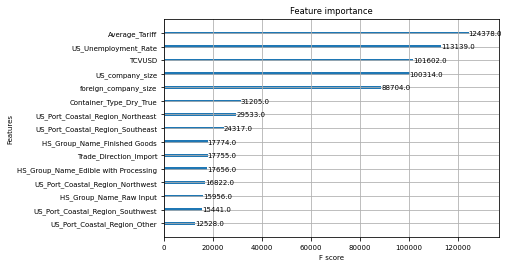

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train20test1819_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
check_additivity = False
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1, check_additivity=check_additivity)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

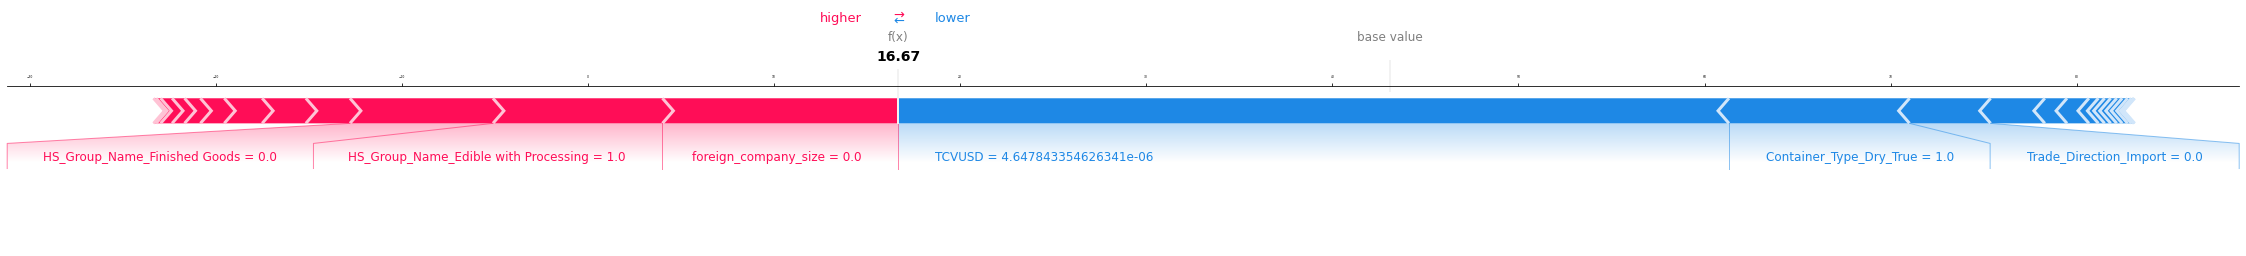

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(40,3)).savefig('XGBoost_HPO_300_GPU_train20test1819_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

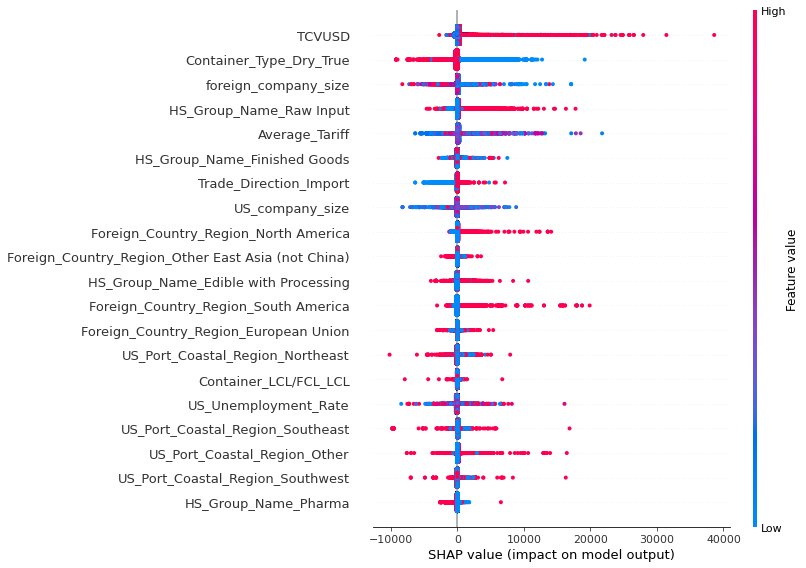

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train20test1819_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test1819_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20test1819_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train20test1819_HPO_300_GPU_WeightsExplain.csv',
           index=False)
exp

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  1.146778  0.008614
1                                      Average_Tariff  0.829866  0.016868
2               Foreign_Country_Region_Southeast Asia  0.618325  0.010823
3                             Container_Type_Dry_True  0.567544  0.010637
4                                foreign_company_size  0.395338  0.012757
5                                     US_company_size  0.201767  0.005405
6   Foreign_Country_Region_Middle East & North Africa  0.174907  0.007853
7                                US_Unemployment_Rate  0.149742  0.001720
8                              Trade_Direction_Import  0.147670  0.003296
9                Foreign_Country_Region_South America  0.142159  0.000950
10                  Foreign_Country_Region_South Asia  0.131087  0.000591
11          Foreign_Country_Region_Sub Saharan Africa  0.129155  0.007976
12                               HS_Group_Name_Pharma  0.125440  0.001756
13                       HS_Group_Name_Finished Goods  0.115890  0.005209
14                            HS_Group_Name_Raw Input  0.085384  0.003178
15               HS_Group_Name_Edible with Processing  0.083554  0.006968
16                                HS_Group_Name_Vices  0.080619  0.004887
17  Foreign_Country_Region_Other Europe (not Europ...  0.075669  0.001691
18              Foreign_Country_Region_European Union  0.073916  0.002155
19                       US_Port_Coastal_Region_Other  0.069199  0.001591

### Test trained 2020 model on 2010-19

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna() & 
        df.State_Closure_EA_Diff.notna()]
df = df[df['Year'] < 2020]
print('Number of rows and columns:', df.shape)

Number of rows and columns: (24133210, 19)


In [ ]:
# Sample due to memory constraints
df_sample = df.sample(n=10000000)

del df

In [ ]:
# Prepare 2018-19 to fit model train on 2020
X_test1 = df_sample.drop(['Metric_Tons', 'Year', 'DateTime'], axis=1)
y_test1 = df_sample['Metric_Tons']

del df_sample

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2020 Test PreCovid')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2020 Test PreCovid
MAE train: 4.145, test: 20.202
MSE train: 67.579, test: 77690.306
RMSE train: 8.221, test: 278.730
R^2 train: 0.891, test: 0.801


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


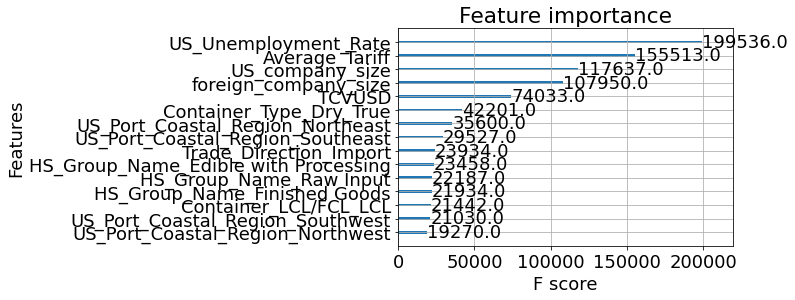

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train20testPreCovid_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
check_additivity = False
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1, check_additivity=check_additivity)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

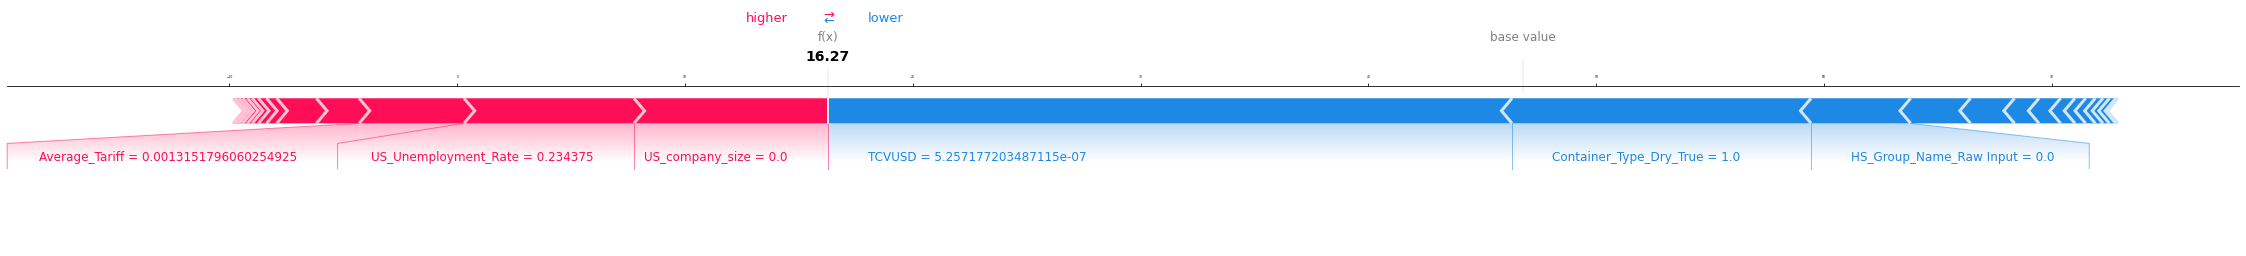

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(40,3)).savefig('XGBoost_HPO_300_GPU_train20testPreCovid_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

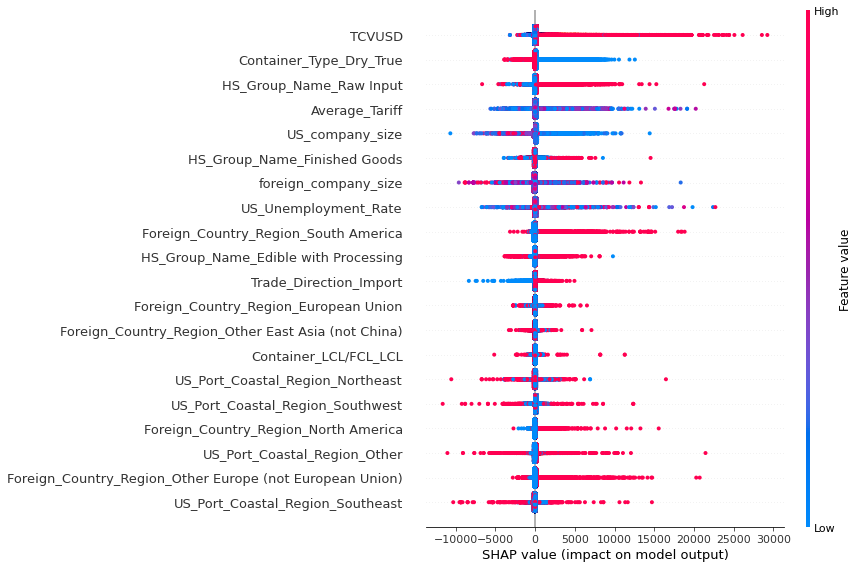

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train20testPreCovid_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20testPreCovid_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train20testPreCovid_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train20testPreCovid_HPO_300_GPU_WeightsExplain.csv',
           index=False)
exp

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  1.330758  0.008578
1                                      Average_Tariff  0.700460  0.010224
2                                US_Unemployment_Rate  0.609144  0.010474
3               Foreign_Country_Region_Southeast Asia  0.415115  0.005761
4                             Container_Type_Dry_True  0.355476  0.003404
5                                     US_company_size  0.347698  0.006293
6   Foreign_Country_Region_Middle East & North Africa  0.310335  0.005604
7                                foreign_company_size  0.308826  0.011842
8                Foreign_Country_Region_South America  0.181200  0.002376
9                                 HS_Group_Name_Vices  0.158507  0.007839
10                            HS_Group_Name_Raw Input  0.102339  0.009222
11  Foreign_Country_Region_Other Europe (not Europ...  0.097826  0.001960
12              Foreign_Country_Region_European Union  0.094422  0.001985
13               HS_Group_Name_Edible with Processing  0.092677  0.005660
14                   US_Port_Coastal_Region_Northwest  0.085042  0.002728
15                               HS_Group_Name_Pharma  0.076287  0.002040
16                       HS_Group_Name_Finished Goods  0.051029  0.003827
17                   US_Port_Coastal_Region_Northeast  0.050142  0.001371
18                       US_Port_Coastal_Region_Other  0.048091  0.002696
19                     Foreign_Country_Region_Oceania  0.044284  0.001896